### Get Book Title and Plot  

In [52]:
from threading import Thread

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wikipediaapi
import wptools

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
import string  

import re
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [2]:
book = pd.read_csv('book.csv')
book = book['name']

In [3]:
wiki_wiki = wikipediaapi.Wikipedia('en')
def get_plot(bookname, firstSection=True):
    try:
        if firstSection :
            p = wiki_wiki.page(bookname)
            sections = p.sections
            s = sections[0]
            return [s.title, s.text]
        else:
            p = wiki_wiki.page(bookname)
            sections = p.sections
            titles = []
            texts = []
            for s in sections:
                titles.append(s.title)
                texts.append(s.text)
            return dict(zip(titles, texts))  
    except:
        pass

def get_wiki(books, book_dict=None, firstSection=True):
    if book_dict is None:
        book_dict = {}
    for i in books:
        book_dict[i] = get_plot(i,firstSection)
    return book_dict

In [4]:
# thread process
def threaded_process(books,nthreads, firstSection=True):
    book_dict = {}
    threads = []
    for i in range(nthreads):
        b = books[i::nthreads]
        t = Thread(target = get_wiki, args =(b,book_dict,firstSection))
        threads.append(t)
    
    # start the threads
    [ t.start() for t in threads ]
    # wait for the threads to finish
    [ t.join() for t in threads ]
    return book_dict

In [6]:
print('Currently, there are %.0f books in the list' % (len(book)))

Currently, there are 35991 books in the list


In [19]:
data = threaded_process(book,100) 

In [20]:
data = pd.DataFrame.from_dict(data).T

data.head(3)

,0,1
Future Perfect (book),Key concepts,The main idea that Johnson promotes in Future ...
The Road (London book),Film adaptation,"The 1973 film Emperor of the North Pole, starr..."
Encyclopedia of Art,Chapters,"Introduction\nGuide to Use\n1. Main body, 2537..."


In [21]:
data.columns = ['section', 'content']

Check how many null values are included and remove them.

In [22]:
data.isnull().sum(axis=0)

section    16324
content    16324
dtype: int64

In [23]:
# remove invalid rows
data = data.dropna(how='any')

Now we need to determine if the first section is the plot.

In [24]:
names = data['section'].unique()
data.section.value_counts()[:50]

Plot summary               3579
Plot                       2892
Contents                   1321
Synopsis                   1118
References                  992
Summary                     871
Background                  836
Plot introduction           718
Reception                   465
See also                    463
Overview                    452
External links              283
Content                     242
History                     191
Characters                  176
Description                 142
Publication history         142
Stories                     133
Publication                  97
Setting                      95
Plot synopsis                95
Notes                        86
Reviews                      83
Awards                       79
Title                        76
Editions                     73
Story                        62
Themes                       58
Author                       57
Critical reception           53
Development                  52
Structur

We can categorize those sections into three types,
- Type one, the first section is plot. For example, when the section title is Plot Summary, Synopsis. 
- Type two, the first section is background of a book, which implies the plot might follow it and be the second or third section of a wiki page, so we need to explore the whole wiki page instead of only the first section.
- Type three, the plot is skipped, for example, when the first section title is References, Reception.

In [25]:
# Type one
plots = ['Plot summary','Plot', 'Contents', 'Synopsis', 'Summary', 'Plot introduction',\
         'Overview', 'Content', 'Description', 'Plot synopsis ', 'Context', 'Plot outline', 'Story outline',
         'Plot Summary', 'Chapters', 'Story', 'Book']

len(data[data.section.isin(plots)])/len(data)


0.5894137387501907

The type one only accounts for 58.9% of the whole dataset. Let's convert it into a clean dataset.

In [111]:
df = data[data.section.isin(plots)].reset_index()
df = df.drop('section', 1) 
df.columns = ['Title', 'Plot']

Now, let's process books of type two.

In [35]:
special = ['Background', 'History', 'Characters', 'Setting','Title', 'Development', \
           'Structure',  'Introduction', 'Inspiration']

print('Books in type two account for %.0f%% of the entire dataset' % (100*len(data[data.section.isin(special)])/len(data)))

Books in type two account for 8% of the entire dataset


Here we scrape the whole page of these books and get plot sections.

In [106]:
specialwiki = list(data[data.section.isin(special)].index)
specialbook = threaded_process(specialwiki, 100, firstSection=False)
specialbook =  pd.DataFrame(specialbook.items()) 

special_book_name = []
special_book_plot = []
for i in range(len(specialbook)):
    if specialbook.iloc[i,1]:
        for k,v in specialbook.iloc[i,1].items():
            if k in plots and len(v)>0:
                special_book_name.append(specialbook.iloc[i,0])
                special_book_plot.append(v)
                continue

In [107]:
special_df= pd.DataFrame(
    {'Title': special_book_name,
     'Plot': special_book_plot,
    }) 

In [108]:
len(special_df)

654

In [112]:
df = df.append(special_df).reset_index().drop('index',1)

In [114]:
len(df)

12246

In [115]:
df.head(5)

,Title,Plot
0,Encyclopedia of Art,"Introduction\nGuide to Use\n1. Main body, 2537..."
1,No Time Like the Present,The novel is set during the period after the l...
2,Time of the Dragon,Time of the Dragon is an accessory for the Dra...
3,Hero Builder's Guidebook,Hero Builder's Guidebook provides assistance t...
4,Brother Dusty-Feet,Hugh Copplestone is an orphaned eleven-year-ol...


Now we get a very clean dataset containing 12246 wiki pages.

In [120]:
df = df.dropna(axis=0, subset=['Plot'])

In [121]:
df.to_csv('plot.csv', index=False)

In [ ]:
## get infobox, do this later
import wptools
for i in range(1):
    try:
        parse = wptools.page(books[i]).get_parse()
        infobox = parse.data.get('infobox', None)
        if infobox:
            author.append(infobox.get('author', None))
            country.append(infobox.get('country', None))
            language.append(infobox.get('language', None))
            genre.append(infobox.get('genre', None))
        else:
            author.append(None)
            country.append(None)
            language.append(None)
            genre.append(None)
            
    except:
        pass

### Clean Data

#### Cleaning Book Names
Some books have (novel) or (book) after the name.

In [3]:
df = pd.read_csv('plot.csv',index_col=False)

In [4]:
for i in range(len(df)):
    if '(' in df['Title'][i]:
        df['Title'][i] = re.sub(r'\(.*?\)', '', df['Title'][i]).strip()

#### Dealing With the Plot Length Distribution

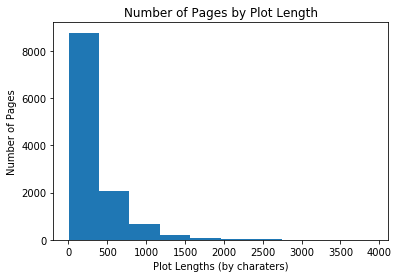

In [5]:
df['length'] = df.Plot.apply(lambda i:len(i.split(' ')))

plt.hist(df['length'])
plt.title('Number of Pages by Plot Length')
plt.xlabel("Plot Lengths (by charaters)")
plt.ylabel("Number of Pages")
plt.show()

In [6]:
print('There are %.2f%% of plots with more than 2000 characters.' % (100*len(df[df.length>=2000])/len(df)))
print('There are %.2f%% of plots with less than 40 characters.' % (100*len(df[df.length<=40])/len(df)))

There are 0.36% of plots with more than 2000 characters.
There are 9.07% of plots with less than 40 characters.


Obviously we do not need the plots with too few words. LDA is not going to assign meaningful topics when the only words to derive topics. So we are going to remove outliers and plots with too few or too many words.

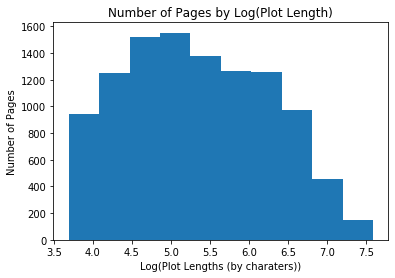

In [7]:
df = df[(df.length<=2000) & (df.length>=40)].reset_index().drop('index',axis=1)

plt.hist(np.log(df['length']))
plt.title('Number of Pages by Log(Plot Length)')
plt.xlabel("Log(Plot Lengths (by charaters))")
plt.ylabel("Number of Pages")
plt.show()

In [8]:
print('Now we have %.0f book pages.' % len(df))

Now we have 10751 book pages.


In [63]:
df = df.drop('length',axis=1)

#### Text Cleanup

Before we switch over to the tokenized articles, we should switch all articles to one line bodies, remove real expression references, remove those parts of the text that are used to distinguish between parts of an article, remove possessives, remove websites, and finally reduce all spaces in the articles to single spaces such that post cleaning we'll have a readable body.

In [10]:
def text_one_liner(book_data):
    for x in range(len(book_data)):
        book_data.loc[x,'Plot'] = book_data.loc[x,'Plot'].replace('\n', '')
    return book_data

df_clean = text_one_liner(df)

In [11]:
def real_exp_remover(book_data):
    for x in range(len(book_data)):
        book_data.loc[x,'Plot'] = re.sub(r'\(.*?\)', '', book_data.loc[x,'Plot'])
        book_data.loc[x,'Plot'] = re.sub(r'\<.*?\>', '', book_data.loc[x,'Plot'])
        book_data.loc[x,'Plot'] = re.sub(r'\[.*?\]', '', book_data.loc[x,'Plot'])
        book_data.loc[x,'Plot'] = re.sub(r'\==.*?\==', '', book_data.loc[x,'Plot'])
    return book_data

df_clean = real_exp_remover(df_clean)

In [14]:
def possessive_fixer(book_data):
    for x in range(len(book_data)):
        book_data.loc[x,'Plot'] = book_data.loc[x,'Plot'].replace("\'", "")
    return book_data

df_clean = possessive_fixer(df_clean)

In [15]:
def website_remover(book_data):
    for x in range(len(book_data)):
        websites = []
        for word in book_data.loc[x,'Plot'].split(' '):
            if word[:4] == 'http':
                websites.append(word)
        
        for website in websites:
            book_data.loc[x,'Plot'] = book_data.loc[x,'Plot'].replace(website, '')
    return book_data

df_clean = website_remover(df_clean)

In [17]:
def space_reducer(book_data):
    for x in range(len(book_data)):
        for i in range(10, 0, -1): #Loop backwards to assure that smaller spaces aren't made by larger deletions and then missed
            large_space = str(i*' ')
            if large_space in book_data.loc[x,'Plot']:
                book_data.loc[x,'Plot'] = book_data.loc[x,'Plot'].replace(large_space, ' ')
    return book_data

df_clean = website_remover(df_clean)

In [55]:
# tokenization, remove punctuation, normalize case, remove stop words
stop_words = set(stopwords.words('english'))
def punctuation_stopWords_remover_lemma(book_data):
    res = []
    for x in range(len(book_data)):
        tokens = word_tokenize(book_data.loc[x,'Plot'])
        table = str.maketrans('', '', string.punctuation)
        words = [w.translate(table).lower() for w in tokens if w.isalpha()]
        words = [lemmatizer.lemmatize(w) for w in words if not w in stop_words]
        res.append(words)
    return res

tokens = punctuation_stopWords_remover(df_clean)
df_clean['tokens'] = tokens

In [57]:
df_clean.head()

,Title,Plot,length,tokens
0,No Time Like the Present,The novel is set during the period after the l...,118,"[novel, set, period, lifting, apartheid, steph..."
1,Time of the Dragon,Time of the Dragon is an accessory for the Dra...,575,"[time, dragon, accessory, dragonlance, campaig..."
2,Brother Dusty-Feet,Hugh Copplestone is an orphaned eleven-year-ol...,547,"[hugh, copplestone, orphaned, boy, living, aun..."
3,The Rose in Splendour: a Story of the Wars of ...,The novel is set in England over a period of e...,62,"[novel, set, england, period, eighteen, months..."
4,The Alleys of Eden,Set in Saigon during the final days of the Vie...,171,"[set, saigon, final, days, vietnam, war, build..."


In [71]:
df_clean.to_csv('clean_data.csv',index=False)

### Data Exploration

In [73]:
## custom function for ngram generation ##
def generate_ngrams(token, n_gram=1):
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

In [82]:
### One Word
from collections import defaultdict

def plot_frequent_words(n_gram):
    freq_dict = defaultdict(int)

    for q in df['tokens']:
        for word in generate_ngrams(q,n_gram):
            freq_dict[word] += 1

    plot_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x:x[1], reverse=True))[0:20]
    plot_sorted.columns = ["word", "wordcount"]

    plt.barh(plot_sorted.word[::-1], plot_sorted.wordcount[::-1])
    plt.title('Frequent Words -'+str(n_gram)+' Word')

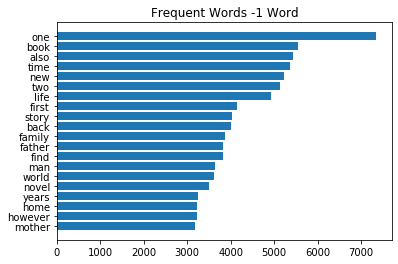

In [83]:
plot_frequent_words(1)

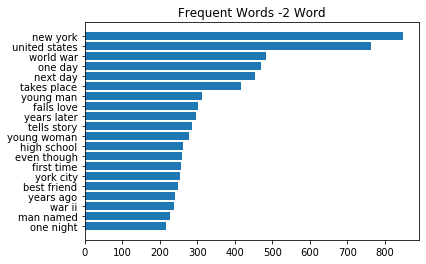

In [84]:
plot_frequent_words(2)

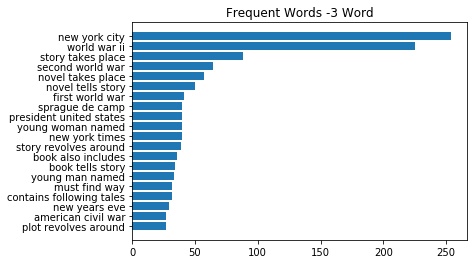

In [85]:
plot_frequent_words(3)